In [ ]:
from datetime import datetime
datetime.now()

datetime.datetime(2024, 12, 3, 12, 3, 52, 676216)

In [ ]:
!pip install transformers torch

In [ ]:
!pip install pythainlp transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 9.5 MB/s eta 0:00:00


# Load Data

Mount


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Load

In [ ]:
import pandas as pd

# ระบุ path ของไฟล์
file_path = '/content/drive/My Drive/DADS7203/thai_news_title_category.csv'

# อ่านข้อมูลในรูปแบบ DataFrame
df = pd.read_csv(file_path)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# แสดงตัวอย่างข้อมูล
df.head()
df['category'].value_counts()
df = df[df['title'].notnull() & df['category'].notnull()]

# Filter Unneeded class
df = df[~df['category'].isin(['Unused', 'Royal News'])]

Down sampling

In [ ]:
# ดูจำนวนตัวอย่างในแต่ละคลาสก่อนการ Down Sampling
print("จำนวนตัวอย่างก่อน Down Sampling:")
print(df['category'].value_counts())

# หาขนาดขั้นต่ำของคลาส
# min_class_size = df['category'].value_counts().min()
min_class_size = 1000

# Down Sampling แบบ Stratify
df_downsampled = (
    df.groupby('category')  # จัดกลุ่มตาม category
    .apply(lambda x: x.sample(n=min_class_size, random_state=42,replace = False) )  # สุ่มตัวอย่างให้แต่ละคลาสมีจำนวนเท่ากัน
    .reset_index(drop=True)
)

# ดูจำนวนตัวอย่างหลัง Down Sampling
print("\nจำนวนตัวอย่างหลัง Down Sampling:")
print(df_downsampled['category'].value_counts())

# แสดงข้อมูลตัวอย่าง
df_downsampled.head()

จำนวนตัวอย่างก่อน Down Sampling:
category
General Affairs         93389
Politics                25729
Sports                  24539
Crime & Justice         16184
International News      15702
Economy & Business      13458
Entertainment           13025
Lifestyle & Culture      7981
Technology & Science     7958
Name: count, dtype: int64

จำนวนตัวอย่างหลัง Down Sampling:
category
Crime & Justice         1000
Economy & Business      1000
Entertainment           1000
General Affairs         1000
International News      1000
Lifestyle & Culture     1000
Politics                1000
Sports                  1000
Technology & Science    1000
Name: count, dtype: int64


<ipython-input-7-2b4ed39728bf>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_class_size, random_state=42,replace = False) )  # สุ่มตัวอย่างให้แต่ละคลาสมีจำนวนเท่ากัน


,labels,title,category
0,อาชญากรรม,ตร.ตรวจสอบตู้เอทีเอ็ม จ.เพชรบุรี พบถูกงัดสูญเง...,Crime & Justice
1,"ข่าว,อาชญากรรม",2 โจรใต้ลอบยิง อส.บาดเจ็บในร้านขายของชำ แข็งใจ...,Crime & Justice
2,อาชญากรรม,"รองปลัดยุติธรรม เข้าพบ ""พล.ต.อ.ปัญญา"" เคลียร์ป...",Crime & Justice
3,"ข่าว,อาชญากรรม",‘โรตารี่พระโขนง’ ระดมทุนหาเครื่องกระตุกหัวใจมอ...,Crime & Justice
4,"ข่าว,อาชญากรรม",หนุ่มกาฬสินธุ์ช็อกดับคาร้านนวดแผนโบราณ มาใช้บร...,Crime & Justice


# Pre processing

TrainTestSplit-->tokenize

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, random_split

# โหลด Tokenizer สำหรับ WangchanBERTa
tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

# แปลง labels ให้เป็นตัวเลข
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_downsampled['category'])

# แบ่งข้อมูล train/test
X_train_titles, X_test_titles, y_train, y_test = train_test_split(df_downsampled['title'].tolist(),  y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Tokenize ข้อมูล
train_tokenized = tokenizer(
    X_train_titles,
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

test_tokenized = tokenizer(
    X_test_titles,
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

# แยกข้อมูล input_ids และ attention_mask
X_train_ids = train_tokenized["input_ids"]
X_train_mask = train_tokenized["attention_mask"]

X_test_ids = test_tokenized["input_ids"]
X_test_mask = test_tokenized["attention_mask"]

y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

# สร้าง Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

# สร้าง Dataset
train_dataset = CustomDataset(X_train_ids, X_train_mask, y_train_tensor)
test_dataset = CustomDataset(X_test_ids, X_test_mask, y_test_tensor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

# Modeling

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW
from transformers.trainer_callback import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import random_split
import time

# โหลด WangchanBERTa Tokenizer และ Model
tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")
model = AutoModelForSequenceClassification.from_pretrained(
    "airesearch/wangchanberta-base-att-spm-uncased",
    num_labels=len(label_encoder.classes_)
)

# ปรับ Dropout Layer (ถ้าต้องการ)
# model.config.hidden_dropout_prob = 0.4
# model.config.attention_probs_dropout_prob = 0.4

model.safetensors:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# เปิด wandb
import os
os.environ["WANDB_DISABLED"] = "false"

In [ ]:
from transformers import AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import EarlyStoppingCallback
import time

# ฟังก์ชันคำนวณ Metrics
def compute_metrics(pred):
    logits, labels = pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return {"eval_accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# แบ่งข้อมูล validation set (ถ้าคุณยังไม่มี eval_dataset)
X_train_titles, X_val_titles, y_train, y_val = train_test_split(df_downsampled['title'].tolist(),  y_encoded, test_size=0.1, random_state=42, stratify=y_encoded)

# Tokenize ข้อมูล validation set
val_tokenized = tokenizer(
    X_val_titles,
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

# แยกข้อมูล input_ids และ attention_mask ของ validation set
X_val_ids = val_tokenized["input_ids"]
X_val_mask = val_tokenized["attention_mask"]

y_val_tensor = torch.tensor(y_val)

# สร้าง Dataset สำหรับ validation
val_dataset = CustomDataset(X_val_ids, X_val_mask, y_val_tensor)

# ตั้งค่า Training Arguments
training_args = TrainingArguments(
    output_dir="./WangchanBERTa_results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.1,
    save_strategy="epoch",
    save_total_limit=3,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    lr_scheduler_type="linear",
)

# ใช้ Early Stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# กำหนด Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.1)

# สร้าง Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # ใช้ validation dataset ที่สร้างขึ้น
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),  # ใช้ default scheduler
    callbacks=[early_stopping]
)

# เริ่มจับเวลา
start_time = time.time()

# เริ่มการเทรน
trainer.train()

# หยุดจับเวลา
end_time = time.time()

# แสดงผลเวลาในการฝึก
runtime = end_time - start_time
print(f"เวลาในการฝึกโมเดล: {runtime:.2f} วินาที")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.045400,0.890808,0.712222,0.707959,0.711664,0.712222
2,0.660300,0.686391,0.770000,0.762053,0.764245,0.770000
3,0.669300,0.652275,0.783333,0.777004,0.778270,0.783333
4,0.429400,0.682375,0.778889,0.763488,0.764427,0.778889
5,0.348800,0.645453,0.785556,0.780996,0.782988,0.785556
6,0.375700,0.695141,0.794444,0.788530,0.788065,0.794444
7,0.265900,0.707902,0.800000,0.789552,0.792393,0.800000
8,0.238800,0.746503,0.794444,0.791329,0.791790,0.794444
9,0.159800,0.796603,0.798889,0.793356,0.793733,0.798889
10,0.163600,0.856491,0.792222,0.789829,0.789535,0.792222


เวลาในการฝึกโมเดล: 1654.43 วินาที


###ต้องตรวจสอบการคำนวณ

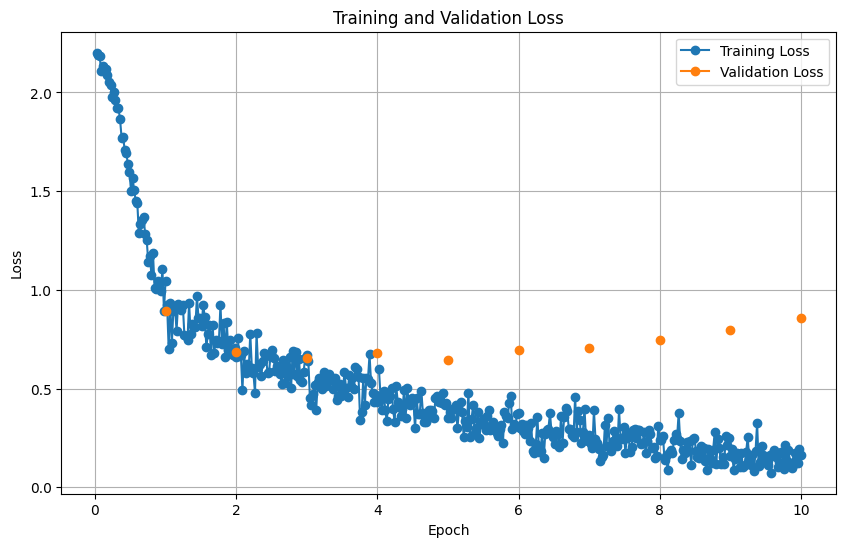

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from transformers import Trainer
import torch
from torch.utils.data import Dataset

# บันทึก Training Logs
logs = pd.DataFrame(trainer.state.log_history)

# สร้างกราฟ Training/Validation Loss
plt.figure(figsize=(10, 6))

# แสดงกราฟ Training Loss
plt.plot(logs["epoch"], logs.get("loss", []), label="Training Loss", marker='o', linestyle='-')
# แสดงกราฟ Validation Loss
plt.plot(logs["epoch"], logs.get("eval_loss", []), label="Validation Loss", marker='o', linestyle='-')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

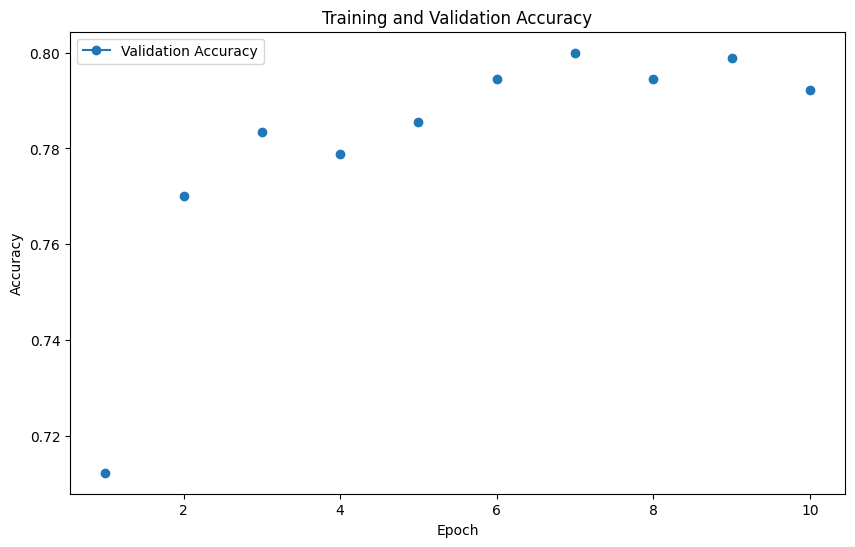

In [ ]:
# สร้างกราฟ Training/Validation Accuracy
if "eval_accuracy" in logs.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(logs["epoch"], logs.get("eval_accuracy", []), label="Validation Accuracy", marker='o')
    if "train_accuracy" in logs.columns:
        plt.plot(logs["epoch"], logs.get("train_accuracy", []), label="Training Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Evaluation


Classification Report:
                      precision    recall  f1-score   support

     Crime & Justice       0.70      0.82      0.76       200
  Economy & Business       0.82      0.85      0.83       200
       Entertainment       0.87      0.86      0.86       200
     General Affairs       0.60      0.35      0.45       200
  International News       0.82      0.91      0.86       200
 Lifestyle & Culture       0.83      0.87      0.85       200
            Politics       0.86      0.83      0.85       200
              Sports       0.95      0.94      0.94       200
Technology & Science       0.75      0.81      0.78       200

            accuracy                           0.81      1800
           macro avg       0.80      0.81      0.80      1800
        weighted avg       0.80      0.81      0.80      1800



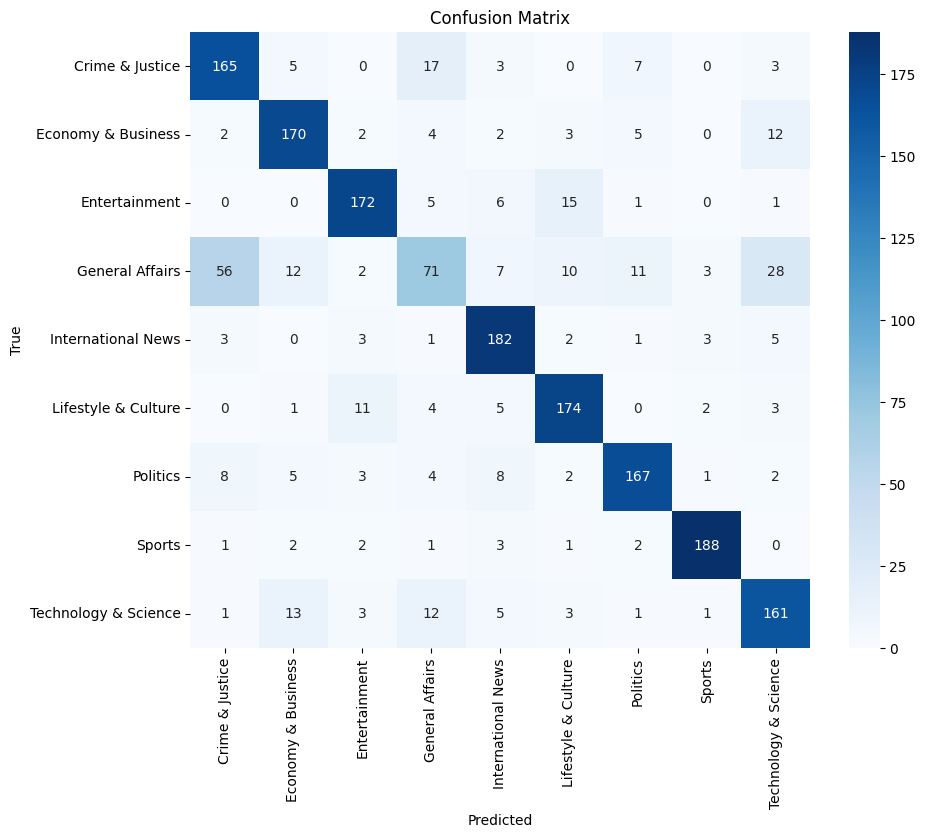

In [ ]:
# ทำนายผล
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)

# แปลง Label กลับเป็นชื่อ Category
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# แสดงผล classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# แสดง Confusion Matrix ในรูปแบบ Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Test - Inference

In [ ]:
# ตัวอย่างข้อความที่ต้องการทำนาย
sample_sentences = [
    "ตลาดหุ้นวันนี้ปรับตัวลดลงเล็กน้อย",
    "ทีมชาติไทยชนะเลิศในเกมสำคัญ",
    "เทคโนโลยี AI ช่วยพัฒนาธุรกิจ",
    "ประชาชนเรียกร้องความยุติธรรมจากตำรวจ"
]

# Tokenize ข้อความตัวอย่าง
sample_tokenized = tokenizer(
    sample_sentences,
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

# ดึง input_ids และ attention_mask จากข้อความตัวอย่าง
sample_input_ids = sample_tokenized["input_ids"]
sample_attention_mask = sample_tokenized["attention_mask"]

# สร้าง Custom Dataset สำหรับข้อความตัวอย่าง (ไม่มี labels)
class InferenceDataset(Dataset):
    def __init__(self, input_ids, attention_mask):
        self.input_ids = input_ids
        self.attention_mask = attention_mask

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
        }

# สร้าง Inference Dataset
sample_dataset = InferenceDataset(sample_input_ids, sample_attention_mask)

# ใช้ Trainer ในการทำนายผล
sample_predictions = trainer.predict(sample_dataset)

# ดึงค่าผลลัพธ์ที่เป็น logits และหาค่าที่มีความน่าจะเป็นสูงสุด
sample_y_pred = sample_predictions.predictions.argmax(axis=1)

# แปลงผลลัพธ์กลับเป็นชื่อ Category
sample_y_pred_labels = label_encoder.inverse_transform(sample_y_pred)

# แสดงผลลัพธ์
print("\nผลการ Inference:")
for sentence, label in zip(sample_sentences, sample_y_pred_labels):
    print(f"ข้อความ: \"{sentence}\" → หมวดหมู่: {label}")


ผลการ Inference:
ข้อความ: "ตลาดหุ้นวันนี้ปรับตัวลดลงเล็กน้อย" → หมวดหมู่: Economy & Business
ข้อความ: "ทีมชาติไทยชนะเลิศในเกมสำคัญ" → หมวดหมู่: Sports
ข้อความ: "เทคโนโลยี AI ช่วยพัฒนาธุรกิจ" → หมวดหมู่: Technology & Science
ข้อความ: "ประชาชนเรียกร้องความยุติธรรมจากตำรวจ" → หมวดหมู่: Crime & Justice
